<a href="https://colab.research.google.com/github/pranjul6386/Age_gender_emotion/blob/main/face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/Datasets/emotion.zip"

In [26]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import PIL.Image
import cv2
from sklearn.utils import shuffle
import keras

from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,Adamax,RMSprop
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint


48 48


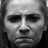

In [3]:
img=PIL.Image.open("/content/ck/CK+48/anger/S014_003_00000028.png")
h,w=img.size
print(h,w)
img

In [6]:
input_dir="/content/ck/CK+48"
images=[]
labels=[]
for dir in os.listdir(input_dir):
  for img in os.listdir(input_dir + "/"+dir):
    img_path=input_dir+ "/"+dir+"/"+img
    image=cv2.imread(img_path)
    images.append(image)
    labels.append(dir)

In [8]:
print(len(images))
print(len(labels))

981
981


In [9]:
image_array=np.array(images)
label_array=np.array(labels)

In [10]:
print(image_array.shape)
print(label_array.shape)

(981, 48, 48, 3)
(981,)


In [ ]:
label_array.reshape((981,1))

In [17]:
num_classes = 7

num_of_samples = image_array.shape[0]
labels_arr= np.ones((num_of_samples,),dtype='int64')

labels_arr[0:134]=0 #135
labels_arr[135:188]=1 #54
labels_arr[189:365]=2 #177
labels_arr[366:440]=3 #75
labels_arr[441:647]=4 #207
labels_arr[648:731]=5 #84
labels_arr[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [19]:
Y = np_utils.to_categorical(labels_arr, num_classes)

#Shuffle the dataset
x,y = shuffle(image_array,Y, random_state=2)
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [21]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(784, 48, 48, 3)
(197, 48, 48, 3)
(784, 7)
(197, 7)


In [27]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')

    return model

In [28]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
activation (Activation)      (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)         

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

In [32]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [33]:
BS = 8
EPOCHS = 200
result = []
scores_loss = []
scores_acc = []
k_no = 0

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "/content/emotion_weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))

    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [36]:
print(scores_acc,scores_loss)

[0.5837563276290894, 0.581632673740387, 0.7193877696990967, 0.6785714030265808, 0.6377550959587097] [1.075404405593872, 1.1678558588027954, 1.0697120428085327, 0.9379023313522339, 0.991356372833252]


In [37]:
value_min=min(scores_loss)
min_index=scores_loss.index(value_min)
print(min_index,value_min)

3 0.9379023313522339


In [40]:
model.load_weights("/content/emotion_weights_best_"+str(min_index)+".hdf5")


In [42]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 0.7688725590705872
Test accuracy: 0.7309644818305969


<Figure size 432x288 with 0 Axes>

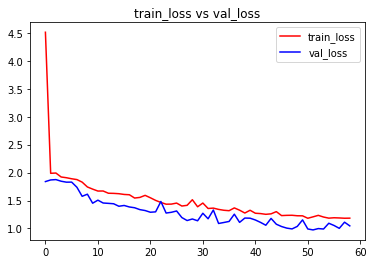

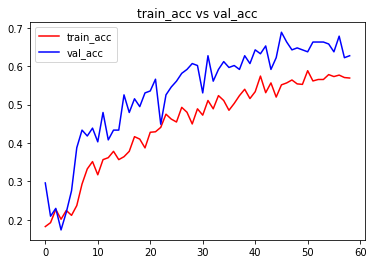

<Figure size 432x288 with 0 Axes>

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt


train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [46]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
np.where(y_test == 1)[1]

array([0, 2, 6, 6, 2, 2, 6, 6, 4, 2, 2, 2, 4, 4, 5, 6, 1, 6, 4, 2, 2, 6,
       6, 4, 2, 4, 6, 0, 5, 3, 2, 5, 6, 3, 4, 2, 2, 3, 0, 5, 5, 6, 6, 2,
       4, 0, 6, 6, 6, 6, 6, 0, 6, 2, 1, 6, 0, 6, 4, 3, 4, 6, 4, 6, 4, 2,
       2, 6, 4, 4, 5, 5, 3, 6, 2, 2, 2, 0, 6, 6, 4, 1, 6, 0, 0, 6, 6, 6,
       5, 4, 4, 0, 0, 3, 6, 0, 6, 1, 6, 1, 6, 0, 2, 6, 0, 0, 3, 0, 2, 4,
       6, 6, 2, 0, 6, 6, 0, 0, 0, 2, 6, 2, 2, 2, 4, 4, 6, 3, 2, 6, 3, 2,
       1, 4, 6, 2, 4, 2, 4, 6, 2, 6, 1, 3, 6, 5, 6, 2, 0, 1, 2, 2, 6, 5,
       6, 2, 2, 2, 4, 4, 2, 4, 6, 4, 2, 4, 6, 2, 4, 6, 4, 4, 6, 6, 6, 4,
       6, 6, 6, 4, 6, 4, 5, 6, 1, 6, 2, 0, 0, 4, 4, 2, 2, 2, 4, 0, 0])

In [49]:
from sklearn.metrics import confusion_matrix
results = model.predict_classes(x_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [50]:
cm

array([[14,  0,  7,  0,  4,  0,  0],
       [ 6,  0,  2,  0,  1,  0,  0],
       [ 0,  0, 44,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  7,  0,  0],
       [ 3,  0,  0,  0, 29,  0,  5],
       [ 0,  0,  1,  0,  2,  0,  8],
       [ 1,  0,  0,  0,  3,  0, 57]])

In [51]:
import seaborn as sns
label_map = ['anger','contempt','disgust','fear','happy','sadness','surprise']
cm_df = pd.DataFrame(cm, index = label_map,
                     columns = label_map
                    )

In [52]:
cm_df

,anger,contempt,disgust,fear,happy,sadness,surprise
anger,14,0,7,0,4,0,0
contempt,6,0,2,0,1,0,0
disgust,0,0,44,0,0,0,0
fear,0,0,3,0,7,0,0
happy,3,0,0,0,29,0,5
sadness,0,0,1,0,2,0,8
surprise,1,0,0,0,3,0,57


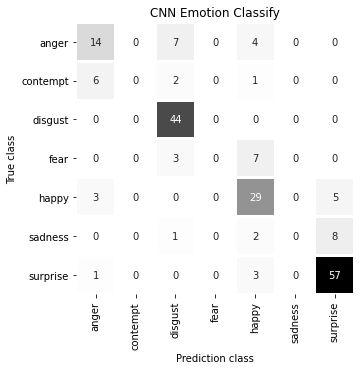

In [56]:
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()